In [23]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib import dates
import datetime as dt
import seaborn as sns

#sklearn functionality
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

pd.options.display.float_format = "{:.2f}".format
sns.set()
%matplotlib inline

# dataset from: https://www.kaggle.com/jessevent/all-crypto-currencies

In [3]:
data = pd.read_csv('~/Desktop/Data/crypto-markets.csv')
data['date'] = pd.to_datetime(data['date'])
data['marcap_bil'] = data['market']/1000000000

## Basic EDA

One of the first and most important tasks in coming to terms with a new data source is taking the time to figure out such basic facts as what kinds of values are in the various cells, how many columns there are and what each represents, how much data there is, etc. 

This is called 'exploratory data analysis', or EDA for short, and it's almost always step number one in any project involving data. 

In [4]:
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,marcap_bil
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00,1488566728.00,0.54,3.88,1.49
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00,1603768865.00,0.78,13.49,1.60
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00,1542813125.00,0.38,12.88,1.54
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00,1298954594.00,0.29,32.17,1.30
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00,1168517495.00,0.39,33.32,1.17


What are we looking at here? 

open = The price of the coin at the opening of the market  
high = The highest price of the coin over a given day.   
low = The lowest price of the coin over a given day.   
volume = Transaction volume for the coin over the given day.   
market = The coin's 'market capitalization' for a given day, calculated by multiplying total number of coins by the value per coin. This gives a general sense of the total value for an asset in a market.   
close_ratio = (closing price - daily low) / (daily high - daily low)   
spread = (daily high - daily low)  
marcap_bil = just the market cap divided by billions, to make graphing easier. 

In [5]:
# for determining how many data points there are and what values we can
# expect to find.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 14 columns):
slug           942297 non-null object
symbol         942297 non-null object
name           942297 non-null object
date           942297 non-null datetime64[ns]
ranknow        942297 non-null int64
open           942297 non-null float64
high           942297 non-null float64
low            942297 non-null float64
close          942297 non-null float64
volume         942297 non-null float64
market         942297 non-null float64
close_ratio    942297 non-null float64
spread         942297 non-null float64
marcap_bil     942297 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(3)
memory usage: 100.6+ MB


In [6]:
data.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,marcap_bil
count,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00,942297.00
mean,1000.17,348.35,408.59,296.25,346.10,8720383.29,172505976.17,0.46,112.34,0.17
std,587.58,13184.36,16163.86,10929.31,13098.22,183980157.98,3575589517.50,0.33,6783.71,3.58
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00
25%,465.00,0.00,0.00,0.00,0.00,175.00,29581.00,0.16,0.00,0.00
50%,1072.00,0.02,0.03,0.02,0.02,4278.00,522796.00,0.43,0.00,0.00
75%,1484.00,0.23,0.25,0.20,0.23,119090.00,6874647.00,0.75,0.03,0.01
max,2072.00,2298390.00,2926100.00,2030590.00,2300740.00,23840899072.00,326502485530.00,1.00,1770563.00,326.50


Rather a lot can be discerned from just this small sample. 

## Some simple analytic graphs

In [7]:
# Since there are lots of coins we'll narrow our research down to just the 
# top 10 by market cap. 

top_10 = data.groupby(['name'])['market'].last().sort_values(ascending=False).head(10).index
data_10 = data[data['name'].isin(top_10)]

Text(0.5, 1.0, 'The top 10 cryptocurrencies by market cap')

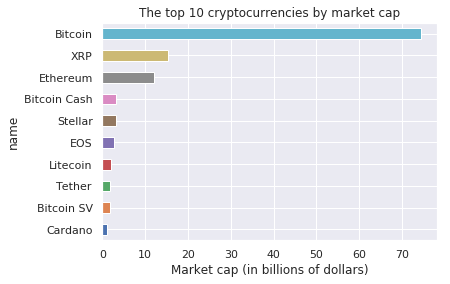

In [8]:
ax = data_10.groupby(['name'])['marcap_bil'].last().sort_values(ascending=False).sort_values().plot(kind='barh')
ax.set_xlabel("Market cap (in billions of dollars)")
plt.title("The top 10 cryptocurrencies by market cap")

Text(0.5, 1.0, 'The top 10 cryptocurrencies by transaction volume')

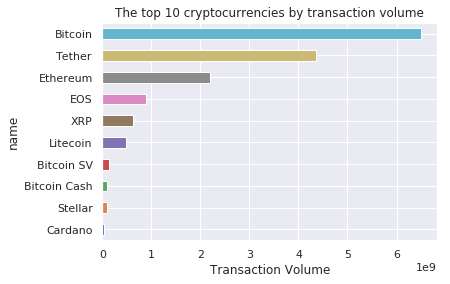

In [9]:
ax = data_10.groupby(['name'])['volume'].last().sort_values(ascending=False).sort_values().plot(kind='barh')
ax.set_xlabel("Transaction Volume")
plt.title("The top 10 cryptocurrencies by transaction volume")

Text(0.5, 1.0, 'Price (in dollars) for 1 unit of currency')

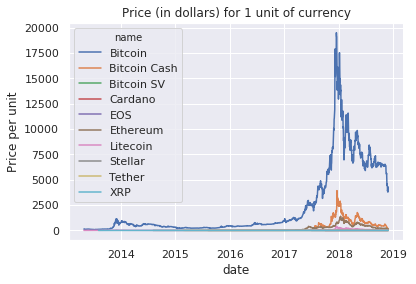

In [10]:
ax = data_10.groupby(['date','name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per unit")
plt.title("Price (in dollars) for 1 unit of currency")

Text(0.5, 1.0, 'Per-currency Market Cap')

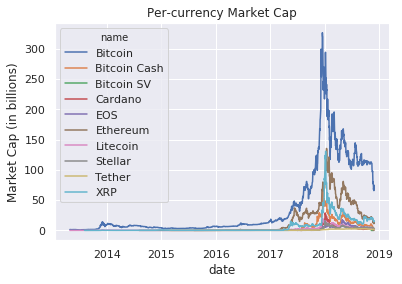

In [11]:
ax = data_10.groupby(['date','name'])['marcap_bil'].mean().unstack().plot()
ax.set_ylabel('Market Cap (in billions)')
plt.title("Per-currency Market Cap")

Text(0.5, 1.0, 'Per-currency Average Transaction Volume')

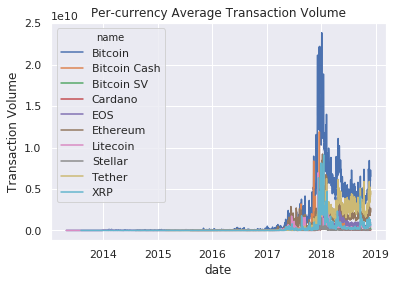

In [12]:
ax = data_10.groupby(['date','name'])['volume'].mean().unstack().plot()
ax.set_ylabel('Transaction Volume')
plt.title("Per-currency Average Transaction Volume")

It can often be useful to see how different currencies correlate with one another, especially if one coin might furnish a leading indicator for another coin. 

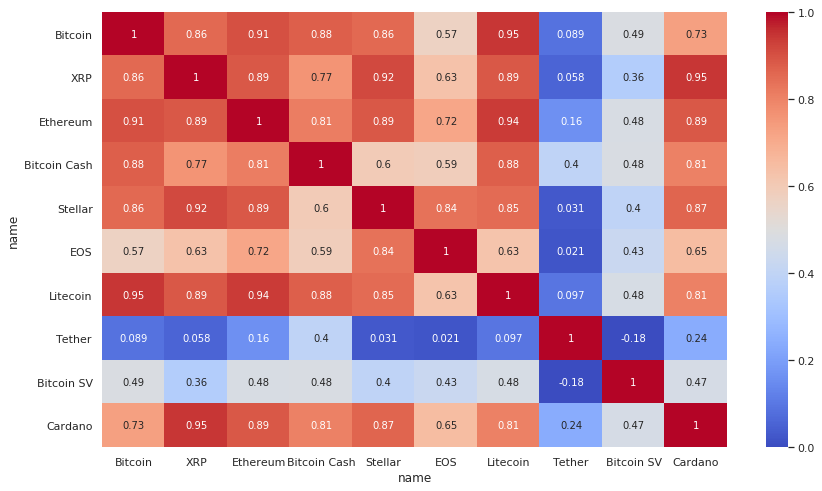

In [13]:
closing = data.groupby(['date', 'name'])['close'].last().unstack()

plt.figure(figsize=(14,8))
sns.heatmap(closing[top_10].corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True)

It's interesting to see that Tether is poorly correlated with basically everything, where as Litecoin is reasonably predictive across the board. 

## But what's our ROI? 

What we really care about, of course, is what happens to a dollar that we send into the cryptomarkets? What do we get back? 

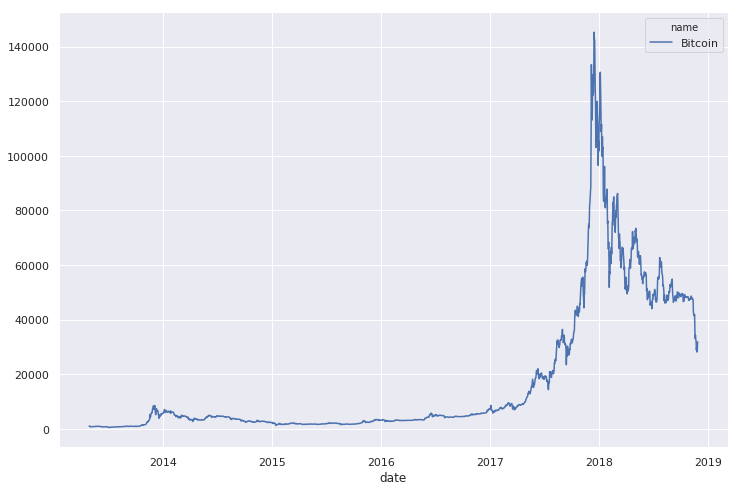

In [14]:
def roi_plot(amt, coin):
    ((amt/coin.iloc[0]) * coin).plot(figsize=(12,8))
    
# 1000/closing['Bitcoin'].iloc[0]
roi_plot(1000, closing[['Bitcoin']])

## Candlestick Charts

Candlestick charts, so named because of their resemblance to a candle with a wick at the top and a wick at the bottom, are a ubiquitous piece of analytical machinery. The 'real body' of the candlesick represents the actual price movements over a given interval of time, usually one day. The closing price is the top of the candle body, the opening price is the bottom. Similarly, the highest price in a day is represented by the top wick and the lowest price in a day is represented by the bottom wick. 

Taken together, these four data points give an investor an excellent idea as to how an asset is behaving over a day, whether or not it is fluctuating wildly, whether or not its opening and closing prices are a good indicator of how high or low the price tends to get, etc. 

In [15]:
Bitcoin = data[data['ranknow'] == 1]
Ethereum = data[data['ranknow'] == 2]
Ripple  = data[data['ranknow'] == 3]


BitOHLC = Bitcoin[['date','open','high','low','close']]
EthOHLC = Ethereum[['date','open','high','low','close']]
RipOHLC = Ripple[['date','open','high','low','close']]


BitOHLC['date'] = pd.to_datetime(BitOHLC['date'])
BitOHLC['date'] = mdates.date2num(BitOHLC['date'].astype(dt.date))
RipOHLC['date'] = pd.to_datetime(RipOHLC['date'])
RipOHLC['date'] = mdates.date2num(RipOHLC['date'].astype(dt.date))
EthOHLC['date'] = pd.to_datetime(EthOHLC['date'])
EthOHLC['date'] = mdates.date2num(EthOHLC['date'].astype(dt.date))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

No handles with labels found to put in legend.


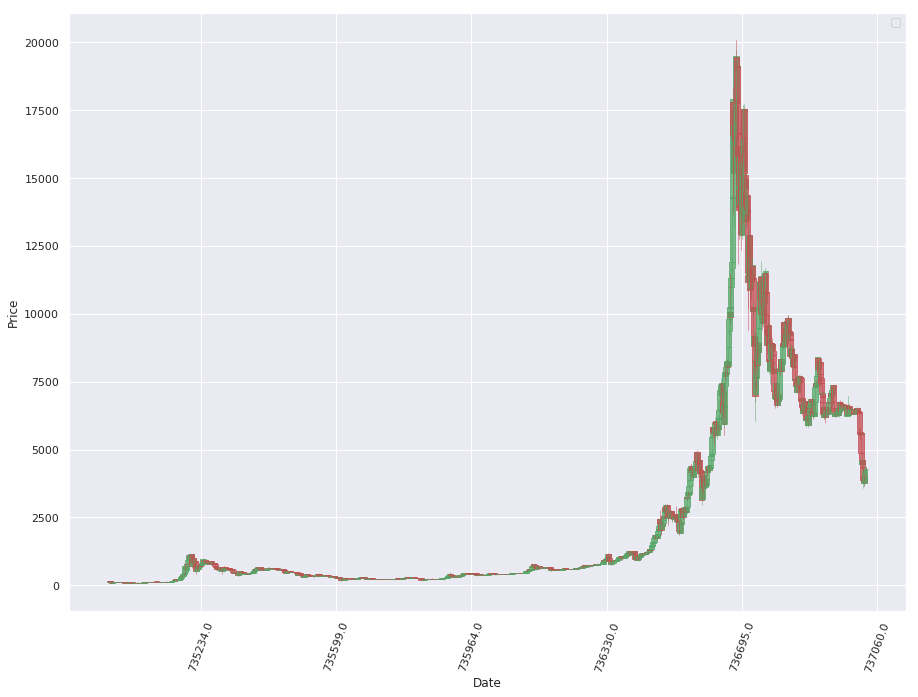

In [20]:
f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
plt.xlabel("Date")
candlestick_ohlc(ax, BitOHLC.values, width=15, colorup='g', colordown='r', alpha=0.75)
ax.set_xticklabels(ax.get_xticks(),rotation=70)
plt.ylabel("Price")
plt.legend()
plt.show()

No handles with labels found to put in legend.


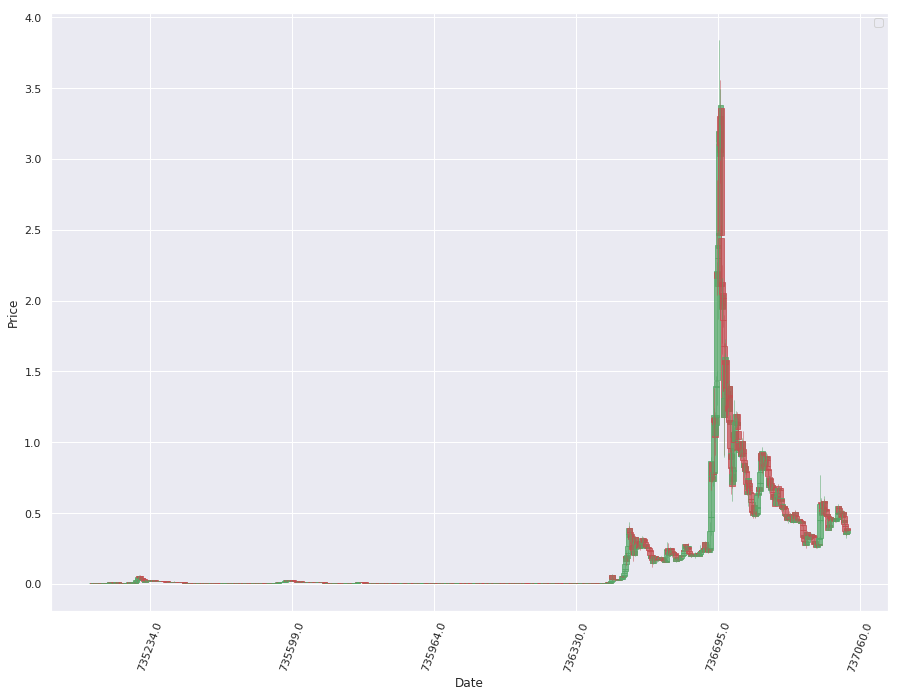

In [21]:
f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
plt.xlabel("Date")
candlestick_ohlc(ax,EthOHLC.values, width=15, colorup='g', colordown='r', alpha=0.75)
ax.set_xticklabels(ax.get_xticks(),rotation=70)
# ax.xaxis.set_major_formatter(hfmt)
plt.ylabel("Price")
plt.legend()
plt.show()

No handles with labels found to put in legend.


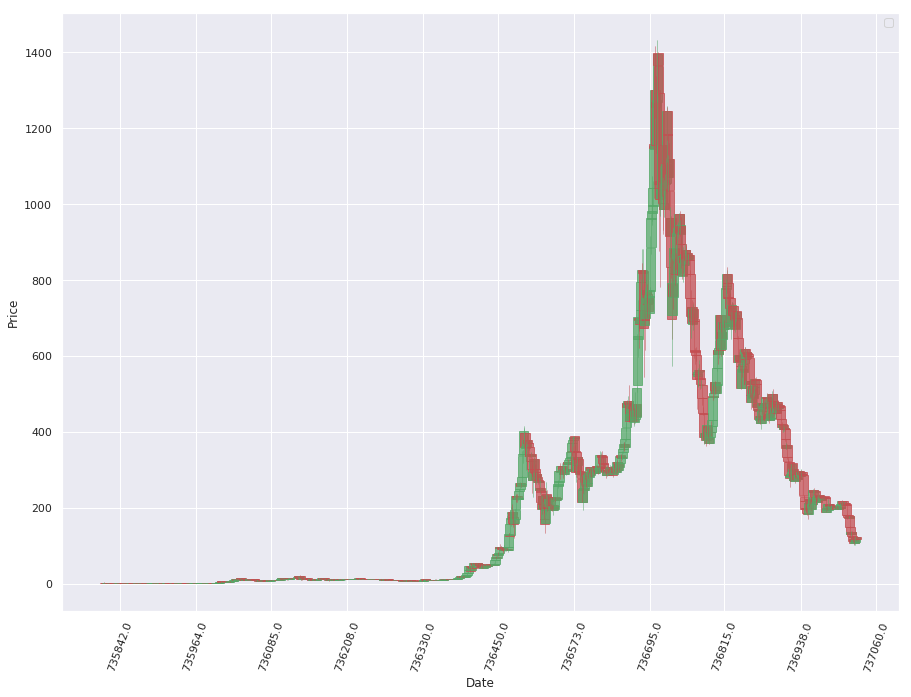

In [22]:
f,ax=plt.subplots(figsize=(15,11))
ax.xaxis_date()
plt.xlabel("Date")
candlestick_ohlc(ax,RipOHLC.values, width=15, colorup='g', colordown='r', alpha=0.75)
ax.set_xticklabels(ax.get_xticks(),rotation=70)
# ax.xaxis.set_major_formatter(hfmt)
plt.ylabel("Price")
plt.legend()
plt.show()

## Lag plot

Lag plots let us detect periodicity within an asset class. If one day of volatile trading tends to be followed by another, this will show up in a lag plot. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


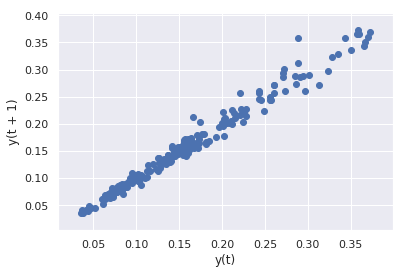

In [25]:
lag_plot(data_10['close'].tail(250))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


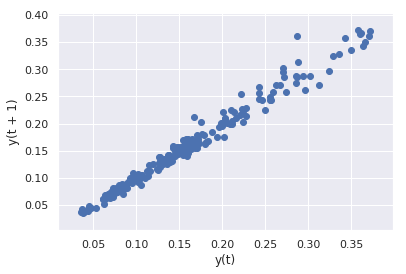

In [26]:
lag_plot(data_10['open'].tail(250))

### References

https://www.kaggle.com/residentmario/time-series-plotting-optional  
https://www.kaggle.com/shelars1985/bitcoin-vs-ethereum-candlestick-chart-at-the-end  
https://www.kaggle.com/amitkumarjaiswal/beginner-s-eda-for-crypto-market